Download torch and torchvision

In [1]:
# pip install torch
# pip install timm

In [2]:
# pip install torchvision

Initialization

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from transformers import Dinov2Model, AutoImageProcessor

In [2]:
from util import *

In [3]:
USE_GPU = True
dtype = torch.float32 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    device = torch.device('cpu')
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 4080 is available.


If the output is "using device: cpu": download CUDA toolkit (https://developer.nvidia.com/cuda-downloads)
https://pytorch.org/get-started/locally/

In [4]:
# data 
random_trans = [v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2)), 
                v2.RandomRotation(degrees=20),
                v2.RandomErasing(p=0.2, scale=(0.05, 0.2), ratio=(0.8, 1.2)), 
                v2.RandomGrayscale(),
                v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                v2.RandomHorizontalFlip(p=0.1)]

transform_train = v2.Compose([v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.RandomApply(random_trans, 0.5)])

transform_eval = v2.Compose([v2.ToImage(), 
                            v2.ToDtype(torch.float32, scale=True)])

In [5]:
class CropButtonDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    # return classes
    def classes(self):
        return self.data.classes

In [6]:
# creat a dictionary that maps index to label
data_dir='../ClassificationDataset_label/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [7]:
button_train = CropButtonDataset('../ClassificationDataset_label/train', transform=transform_train)
loader_train = DataLoader(button_train, batch_size=64, shuffle=True)

button_val = CropButtonDataset('../ClassificationDataset_label/val', transform=transform_eval)
loader_val = DataLoader(button_val, batch_size=20, shuffle=False)

button_test = CropButtonDataset('../ClassificationDataset_label/test', transform=transform_eval)
loader_test = DataLoader(button_test, batch_size=14, shuffle=False)

Check If load correctly

In [8]:
loader_train

In [9]:
for images, labels in loader_val:
    print("Batch loaded!")
    print("Images shape:", images.shape)
    print("Labels:", labels)
    break


Batch loaded!
Images shape: torch.Size([20, 3, 320, 320])
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


Model setup

In [10]:
class Dinov2BinaryClassifier(nn.Module):
    def __init__(
        self,
        backbone_name: str = "facebook/dinov2-small",
        hidden_dim: int = 512,
        dropout_prob: float = 0.4,
    ):
        """
        Param:
            - backbone_name: Hugging Face Dinov2 
            - hidden_dim: hidden dim
            - dropout_prob: dropout ratio
        """
        super().__init__()
        # 1) data preprocessing (check next cell for deatils)
        self.processor = AutoImageProcessor.from_pretrained(backbone_name)

        # 2) load pretrained weight
        self.backbone = Dinov2Model.from_pretrained(backbone_name)

        # 3) Classification Head：CLS token -> hidden_dim -> ReLU -> Dropout
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.config.hidden_size, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, 1),  # BCE 1 dim output
        )

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        """
        Param:
            - pixel_values: shape = (batch_size, 3, image_size, image_size),
        Output:
            - logits: shape = (batch_size, 2) raw score
        """
        # 1) send input into Dinov2 backbone,get last_hidden_state
        #    outputs.last_hidden_state = (batch_size, seq_len, hidden_size)，
        #    seq_len = patch + 1（CLS token）
        outputs = self.backbone(pixel_values=pixel_values)
        last_hidden = outputs.last_hidden_state  # (B, seq_len, hidden)

        # 2) get CLS token：last_hidden[:, 0, :]
        cls_token = last_hidden[:, 0, :]  # (B, hidden_size)

        # 3) sends CLS toekn
        logits = self.classifier(cls_token)  # (B, 2)
        return logits

Check augmentation

In [11]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [12]:
# processor

test backbone

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model
model = Dinov2BinaryClassifier(
    backbone_name="facebook/dinov2-small",
    hidden_dim=512,
    dropout_prob=0.4).to(device)

dummy_images = torch.randn(2, 3, 224, 224).to(device)  # (B=2, C=3, H=224, W=224)

with torch.no_grad():
    logits = model(dummy_images)

print("Logits:", logits)
probs = torch.softmax(logits, dim=-1)
print("Probabilities:", probs)

Logits: tensor([[1.0824],
        [1.2158]], device='cuda:0')
Probabilities: tensor([[1.],
        [1.]], device='cuda:0')


Find best hyperparameter

In [15]:
# arch = ("facebook/dinov2-small", 256, 0.5)
# best_model, best_params, best_training_data, top_5 = hyperparameter_search(Dinov2BinaryClassifier, arch, loader_train, loader_val, device, epochs=35)

In [ ]:
# check_accuracy_final(loader_test, best_model, True)

Train best model

In [21]:
final_model = Dinov2BinaryClassifier(hidden_dim=256, dropout_prob=0.5)

In [22]:
# from torchinfo import summary
# summary(final_model, input_size=(1, 3, 320, 320))

In [25]:
# hard code best paramm
lr = 2.89e-04
wd=1.50e-04 
betas=(0.9, 0.98)

In [26]:
optimizer = torch.optim.AdamW(
            [
                {"params": final_model.backbone.parameters(), "lr": lr / 10},
                {"params": final_model.classifier.parameters(), "lr": lr},
            ],
            weight_decay=wd,
            betas= betas)
data = train(final_model, optimizer, loader_train, loader_val, device, epochs=35)

Iter: 1/70    |  Loss: 0.656024  |  Train Acc: 0.4556  |  Val Acc: 0.5000 
Sample preds : [24.3%, 19.5%, 26.5%, 23.1%, 38.7%, 28.0%, 26.1%, 21.6%, 23.8%, 30.0%, 29.4%, 27.9%, 25.8%, 33.4%, 22.2%, 25.1%, 20.1%, 28.1%, 18.9%, 24.0%]
Sample labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Iter: 2/70    |  Loss: 1.177842  |  Train Acc: 0.5444  |  Val Acc: 0.5000 
Iter: 3/70    |  Loss: 0.814041  |  Train Acc: 0.5444  |  Val Acc: 0.5000 
Sample preds : [55.7%, 55.0%, 58.6%, 50.4%, 63.8%, 59.6%, 63.3%, 56.9%, 56.5%, 53.8%, 61.7%, 59.4%, 61.0%, 56.2%, 58.2%, 60.2%, 58.4%, 50.4%, 52.5%, 51.3%]
Sample labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Iter: 4/70    |  Loss: 0.762623  |  Train Acc: 0.5778  |  Val Acc: 0.5000 
Iter: 5/70    |  Loss: 0.694308  |  Train Acc: 0.5444  |  Val Acc: 0.5000 
Sample preds : [56.1%, 51.7%, 49.3%, 48.2%, 49.5%, 51.0%, 64.3%, 51.4%, 54.4%, 48

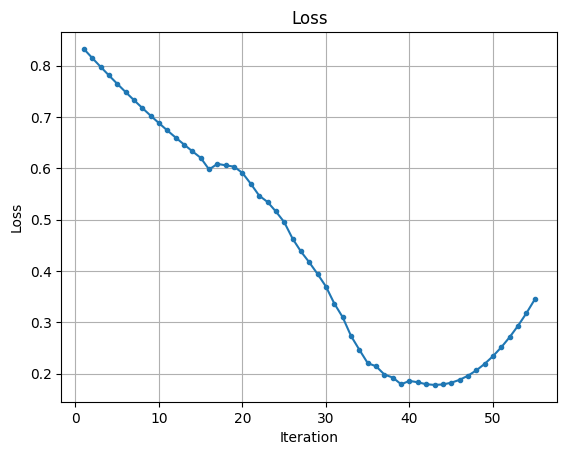

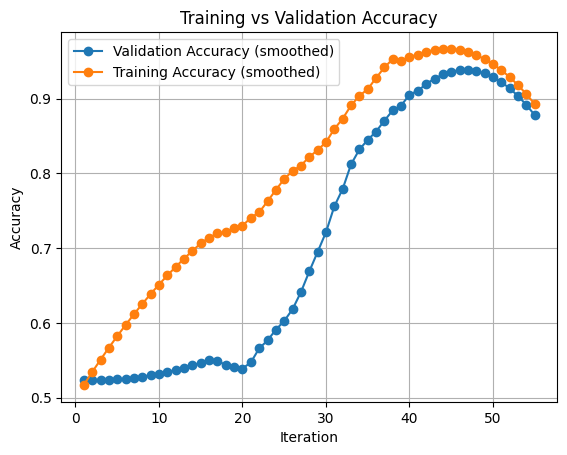

In [27]:
plotpic(data,smooth_window=30)

In [28]:
check_accuracy_final(loader_test, final_model, device, out=True)

Sample preds : [1.6%, 12.2%, 1.6%, 1.7%, 1.3%, 1.7%, 2.6%, 71.4%, 60.2%, 96.0%, 72.9%, 93.1%, 91.2%, 90.1%]
Sample labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


1.0

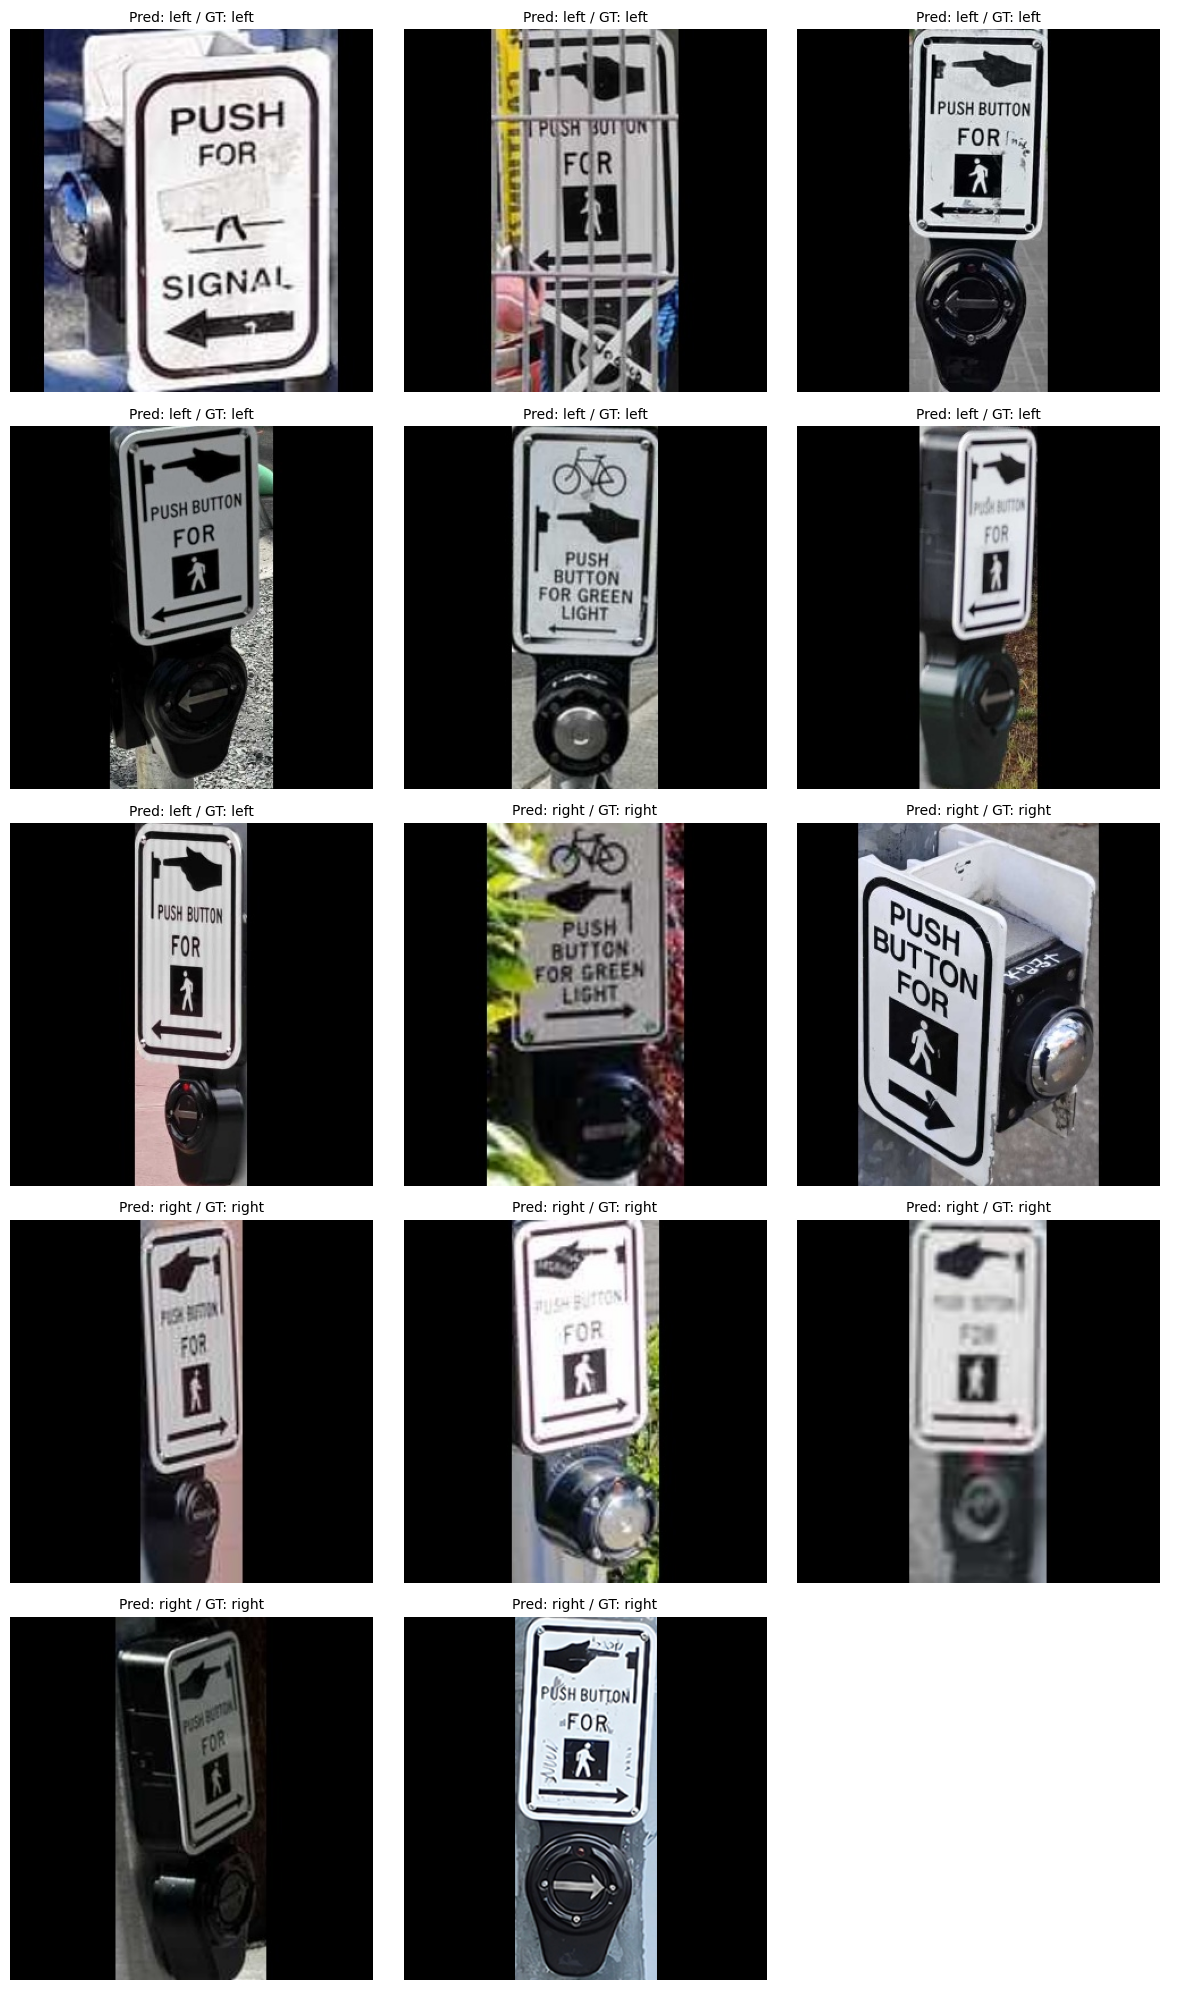

In [29]:
show_predictions_grid(loader_test, final_model, device, class_names=['left', 'right'], max_images=14, images_per_row=3)

Save model

In [30]:
torch.save(final_model.state_dict(), "dinov2_small_256_.5_final_final.pth")